<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


## Imports

In [1]:
#!sudo apt install pv -y
# you should install it if you want a progress bar for extraction in fetch_dataset()

In [2]:
!pip install torchinfo

In [3]:
from copy import deepcopy
import os
import pickle
import random
import subprocess
import time

from IPython.display import clear_output

import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
import numpy as np
import skimage
import skimage.io
import skimage.transform
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torchvision

import torchinfo

import tqdm.notebook as tqdm

import sklearn
import sklearn.model_selection
import sklearn.manifold
import sklearn.cluster
import sklearn.preprocessing

## Setting random seeds for reproducibility

In [4]:
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)
# not enabling deterministic mode since this breaks half of pytorch.

## Determining available device

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Setting globals

In [6]:
TRAIN_TIMES = []
BATCH_SIZE = 256
LATENT_SPACE_SIZE = 512

In [7]:
plt.rcParams["figure.figsize"] = (15, 15)

## Helper functions

In [8]:
def fit_epoch(data_train, model, optimizer, criterion):
    model.train()
    running_loss = 0.0
    processed_data = 0
    for inputs in tqdm.tqdm(data_train, desc="Fitting"):
        try:
            inputs = inputs.to(DEVICE)
            optimizer.zero_grad()
            reconstructions, latent_embeddings = model(inputs)
            loss = criterion(torch.sigmoid(reconstructions), inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            processed_data += inputs.size(0)

            # clearing VRAM
            inputs = inputs.to("cpu")
            del inputs
            torch.cuda.empty_cache()
        except Exception as e:
            # clearing VRAM and reraising error
            inputs = inputs.to("cpu")
            del inputs
            torch.cuda.empty_cache()
            raise e
    train_loss = running_loss / processed_data
    return train_loss
  
def eval_epoch(data_val, model, criterion):
    model.eval()
    running_loss = 0.0
    processed_data = 0
    
    for inputs in tqdm.tqdm(data_val, desc="Validating"):
        try:
            inputs = inputs.to(DEVICE)
            with torch.no_grad():
                reconstructions, latent_embeddings = model(inputs)
                loss = criterion(torch.sigmoid(reconstructions), inputs)

            running_loss += loss.item() * inputs.size(0)
            processed_data += inputs.size(0)
            
            # clearing VRAM
            inputs = inputs.to("cpu")
            del inputs
            torch.cuda.empty_cache()
        except Exception as e:
            # clearing VRAM and reraising error
            inputs = inputs.to("cpu")
            del inputs
            torch.cuda.empty_cache()
            raise e
    val_loss = running_loss / processed_data
    return reconstructions, latent_embeddings, val_loss
  
def train_model(data_train, data_val, model, optimizer, criterion, epochs, batch_size, scheduler=None, start_epoch=0):
    history = []
    log_template = "\nEpoch {ep: 03d} train_loss: {t_loss: 0.4f} \
    val_loss {v_loss: 0.4f}"

    prev_lr = optimizer.param_groups[0]["lr"]

    start_time = time.time()

    with tqdm.tqdm(desc="Epoch", total=epochs) as pbar_outer:
        for epoch in range(start_epoch, epochs):
            train_loss = fit_epoch(data_train, model, optimizer, criterion)
            tqdm.tqdm.write(f"loss: {train_loss}")
            
            outputs, _, val_loss = eval_epoch(data_val, model, criterion)
            
            clear_output(wait=True)
            pbar_outer.update(1)
            tqdm.tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, \
                                                v_loss=val_loss))
            if scheduler is not None:
                  scheduler.step(val_loss)

            history.append((train_loss, val_loss, optimizer.param_groups[0]["lr"]))
        
            show_pics_train(data_val, outputs, model, epoch, val_loss)

            pbar_outer.refresh()
        
    end_time = time.time()
    train_time = end_time - start_time
    TRAIN_TIMES.append(train_time)
    tqdm.tqdm.write(f"Overall training time: {train_time: 0.1f} seconds")

    return history

In [9]:
def show_pics_train(val_loader, outputs, model, epoch, val_loss, sample_size=6):
    inputs = next(iter(val_loader))
    originals = inputs.permute(0, 2, 3, 1).cpu()
    latent_embeddings = model.encode(inputs.to(DEVICE)).detach().cpu()
    reconstructions, _ = model(inputs.to(DEVICE))
    reconstructions = torch.sigmoid(reconstructions).permute(0, 2, 3, 1).detach().cpu()
    if not int(np.sqrt(latent_embeddings.shape[1])) == np.sqrt(latent_embeddings.shape[1]):
        latent_embeddings = F.pad(latent_embeddings, (0, int(np.ceil(np.sqrt(latent_embeddings.shape[1])) ** 2 - latent_embeddings.shape[1])))
    for i in range(sample_size):
        plt.subplot(3, sample_size, i + 1)
        plt.imshow(originals[i].numpy())
        plt.title("Real")
        plt.axis("off")

        plt.subplot(3, sample_size, i + 1 + sample_size)
        plt.imshow(latent_embeddings[i].reshape(int(np.sqrt(len(latent_embeddings[i]))), -1))
        plt.title("Latent embedding")
        plt.axis("off")

        plt.subplot(3, sample_size, i + 1 + 2 * sample_size)
        plt.imshow(reconstructions[i].numpy())
        plt.title("Reconstruction")
        plt.axis("off")
    plt.suptitle("Epoch %d, loss: %f" % (epoch + 1, val_loss))
    plt.show()
    inputs = inputs.to("cpu")
    del inputs
    torch.cuda.empty_cache()

def plot_pics(pics, sample_size=6, mode="reconstructions"):
    for i in range(sample_size):
        plt.subplot(2, sample_size // 2 + 1, i + 1)
        image = pics[i]
        if mode == "reconstructions":
            title = "Reconstructed"
            image = image.permute(1, 2, 0)
        elif mode == "latent_embeddings":
            title = "Latent embedding"
            if not int(np.sqrt(len(image))) == np.sqrt(len(image)):
                image = F.pad(image, (0, int(np.ceil(np.sqrt(len(image))) ** 2 - len(image))))
            image = image.reshape(int(np.sqrt(len(image))), -1)
        else:
            raise ValueError("Unknown plotting mode")
        plt.imshow(image.numpy())
        plt.title(title)
        plt.axis("off")
    plt.show()

def plot_loss(history):
    loss, val_loss, _ = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="Train loss")
    plt.plot(val_loss, label="Validation loss")
    plt.legend(loc="best")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

def plot_learn_rate(history):
    _, _, learn_rates = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(learn_rates, label="Learn rate")
    plt.legend(loc="best")
    plt.xlabel("Epochs")
    plt.ylabel("Learn rate")
    plt.show()

def plot_time_comparisons(*args):
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_axes([0, 0, 1, 1])
    labels = ["AE", "VAE", "CVAE"]
    ax.bar(labels, args)
    ax.set_ylabel(f"Training time")
    ax.set_title(f"Training times for all models")
    plt.show()

In [10]:
def eval_autoencoder(model, data, mode="decode"):
    if mode == "decode":
        run_f = model.decode
        data = data_utils.DataLoader(data, batch_size=BATCH_SIZE, shuffle=False, 
                                     num_workers=torch.multiprocessing.cpu_count(), 
                                     drop_last=False)
    elif mode == "encode":
        run_f = model.encode
    else:
        raise ValueError("Unknown evaluation mode")
    model.eval()  # testing mode
    with torch.no_grad():
        results = []
        for X_batch in tqdm.tqdm(data, desc="Evaluating"):
            try:
                X_batch = X_batch.to(DEVICE)
                outputs = run_f(X_batch).detach().cpu()
                if mode == "decode":
                    outputs = torch.sigmoid(outputs)
                results.append(outputs)
                X_batch = X_batch.to("cpu")
                del X_batch
                torch.cuda.empty_cache()
            except Exception as e:
                X_batch = X_batch.to("cpu")
                del X_batch
                torch.cuda.empty_cache()
                raise e

    return torch.flatten(torch.stack(results), end_dim=1)

In [11]:
def save_model(path, model, optimizer, criterion, epoch, history):
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": criterion,
        "history": history},
        path)

def load_model(path, model_arch, optim_class, optim_kwargs):
    model = model_arch()
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optim = optim_class(model.parameters(), **optim_kwargs)
    optim.load_state_dict(checkpoint["optim_state_dict"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    history = checkpoint["history"]
    model.eval()
    return model, optim, epoch, loss, history

def save_history(path, history):
    with open(path, "wb") as f:
        pickle.dump(history, f)

def load_history(path):
    with open(path, "rb") as f:
        history = pickle.load(f)
        
    return history

## Часть 1. Vanilla Autoencoder (10 баллов)

### 1.1. Подготовка данных (0.5 балла)


In [12]:
def fetch_dataset(attrs_name="lfw_attributes.txt",
                      images_name="lfw-deepfunneled",
                      dx=80, dy=80, 
                      dimx=64, dimy=64
    ):

    # download if not exists
    if not os.path.exists(images_name):
        print("Images not found, downloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz --quiet --show-progress --progress=bar:force:noscroll")
        print("Extracting...")
        os.system("pv --progress --line-mode --size 100 --eta --timer tmp.tgz | tar xz")
        os.system("rm tmp.tgz")
        print("Done.")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("Attributes not found, downloading...")
        os.system(f"wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/{attrs_name} --quiet --show-progress --progress=bar:force:noscroll")
        print("Done.")

    # read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt", sep='\t', skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])

    # read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person': person_id, 'imagenum': photo_number, 'photo_path': fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # mass merge
    # (photos now have same order as attributes)
    df = pd.merge(df_attrs, photo_ids, on = ('person', 'imagenum'))

    assert len(df) == len(df_attrs), "Lost some data when merging dataframes."

    # image preprocessing
    tqdm.tqdm.pandas(desc="Reading and preprocessing images")
    all_photos = df['photo_path'].progress_apply(skimage.io.imread)\
    .progress_apply(lambda img: img[dy:-dy, dx:-dx])\
    .progress_apply(lambda img: skimage.transform.resize(img, [dimx, dimy]))

    all_photos = np.stack(all_photos.values)
    all_attrs = df.drop(["photo_path", "person", "imagenum"], axis=1)

    print("Done.")
    
    return all_photos, all_attrs


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [13]:
photos, attrs = fetch_dataset()

Images not found, downloading...


tmp.tgz             100%[===================>] 103.72M  1.96MB/s    in 60s     


Extracting...
Done.
Attributes not found, downloading...


lfw_attributes.txt  100%[===================>]  14.19M  1.74MB/s    in 13s     


Done.


Reading and preprocessing images:   0%|          | 0/13143 [00:00<?, ?it/s]

Reading and preprocessing images:   0%|          | 0/13143 [00:00<?, ?it/s]

Reading and preprocessing images:   0%|          | 0/13143 [00:00<?, ?it/s]

Done.


In [14]:
def head_photos(photos, sample_size=6):
  plt.figure(figsize=(18, 6))
  for i in range(sample_size):
    plt.subplot(2, sample_size, i + 1)
    plt.axis("off")
    plt.imshow(photos[i])

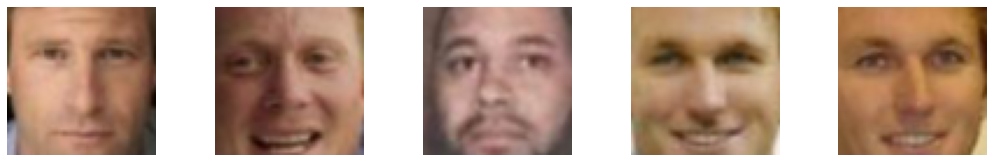

In [15]:
head_photos(photos, sample_size=5)

In [16]:
train, non_train = sklearn.model_selection.train_test_split(photos, train_size=0.7, random_state=RANDOM_STATE, shuffle=False)
val, test = sklearn.model_selection.train_test_split(photos, test_size=0.5, random_state=RANDOM_STATE, shuffle=False)
del non_train, photos

In [17]:
train_t = torch.Tensor(train).permute(0, 3, 1, 2)
val_t = torch.Tensor(val).permute(0, 3, 1, 2)
test_t = torch.Tensor(test).permute(0, 3, 1, 2)

In [18]:
data_train = data_utils.DataLoader(train_t, batch_size=BATCH_SIZE, shuffle=True, 
                                   num_workers=torch.multiprocessing.cpu_count(), 
                                   drop_last = True)
data_val = data_utils.DataLoader(val_t, batch_size=BATCH_SIZE, shuffle=False, 
                                  num_workers=torch.multiprocessing.cpu_count(), 
                                  drop_last = True)
data_test = data_utils.DataLoader(test_t, batch_size=BATCH_SIZE, shuffle=False, 
                                  num_workers=torch.multiprocessing.cpu_count(), 
                                  drop_last = True)

### 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [19]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Flatten(start_dim=1),
            nn.Linear(32 * 8 * 8, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, LATENT_SPACE_SIZE)
        )

        self.decoder = nn.Sequential(
            nn.Linear(LATENT_SPACE_SIZE, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 32 * 8 * 8),
            nn.ReLU(inplace=True),
            nn.Unflatten(dim=1, unflattened_size=(32, 8, 8)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        latent_embedding = self.encode(x)
        reconstruction = self.decode(latent_embedding)
        return reconstruction, latent_embedding

    def encode(self, x):
        return self.encoder(x)

    def decode(self, latent_embedding):
        return self.decoder(latent_embedding)

In [20]:
autoencoder = Autoencoder().to(DEVICE)

In [21]:
torchinfo.summary(autoencoder, (BATCH_SIZE, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              --                        --
├─Sequential: 1-1                        [256, 512]                --
│    └─Conv2d: 2-1                       [256, 8, 32, 32]          224
│    └─ReLU: 2-2                         [256, 8, 32, 32]          --
│    └─Conv2d: 2-3                       [256, 16, 16, 16]         1,168
│    └─BatchNorm2d: 2-4                  [256, 16, 16, 16]         32
│    └─ReLU: 2-5                         [256, 16, 16, 16]         --
│    └─Conv2d: 2-6                       [256, 32, 8, 8]           4,640
│    └─ReLU: 2-7                         [256, 32, 8, 8]           --
│    └─Flatten: 2-8                      [256, 2048]               --
│    └─Linear: 2-9                       [256, 32]                 65,568
│    └─ReLU: 2-10                        [256, 32]                 --
│    └─Linear: 2-11                      [256, 512]                16,896


In [22]:
!nvidia-smi

Fri Dec 31 11:47:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P0    N/A /  N/A |    747MiB /  3020MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэнкодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [23]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=3e-4)

In [24]:
max_epochs = 100


Epoch  100 train_loss:  0.0075     val_loss  0.0074


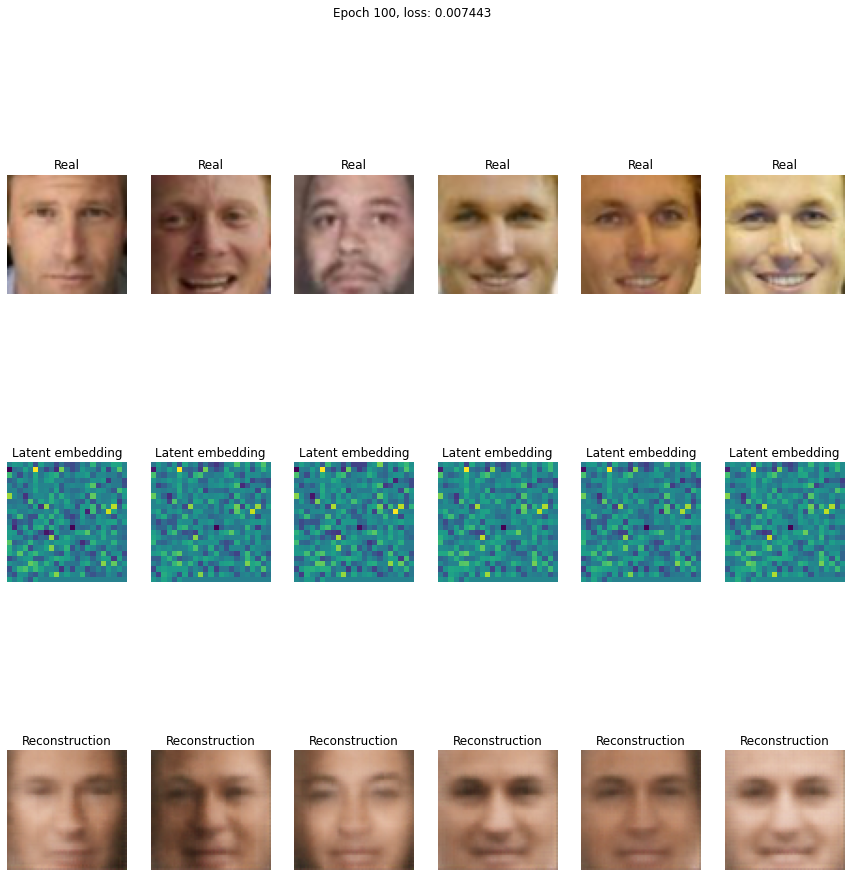

Overall training time:  440.1 seconds


In [25]:
history_vanilla_ae = train_model(data_train, data_val, autoencoder, optimizer, criterion, max_epochs, BATCH_SIZE)

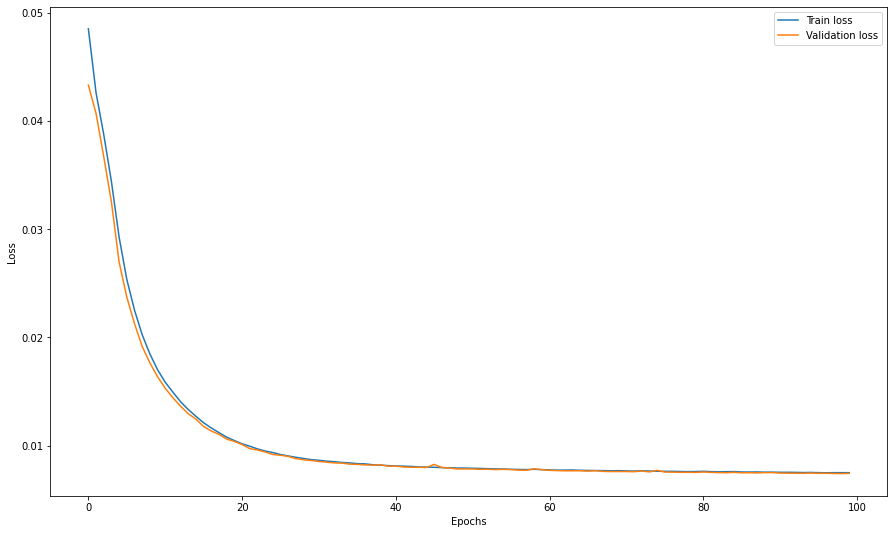

In [26]:
plot_loss(history_vanilla_ae)

Давайте посмотрим, как наш тренированный автоэнкодер кодирует и восстанавливает картинки:

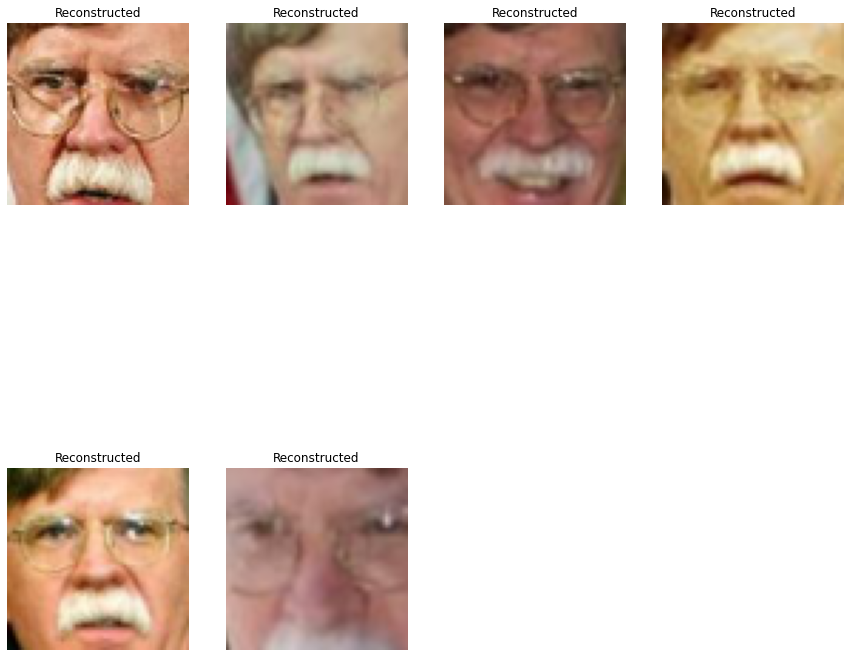

In [27]:
plot_pics(next(iter(data_test)), mode="reconstructions")

In [28]:
latent_embeddings = eval_autoencoder(autoencoder, data_test, mode="encode")

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

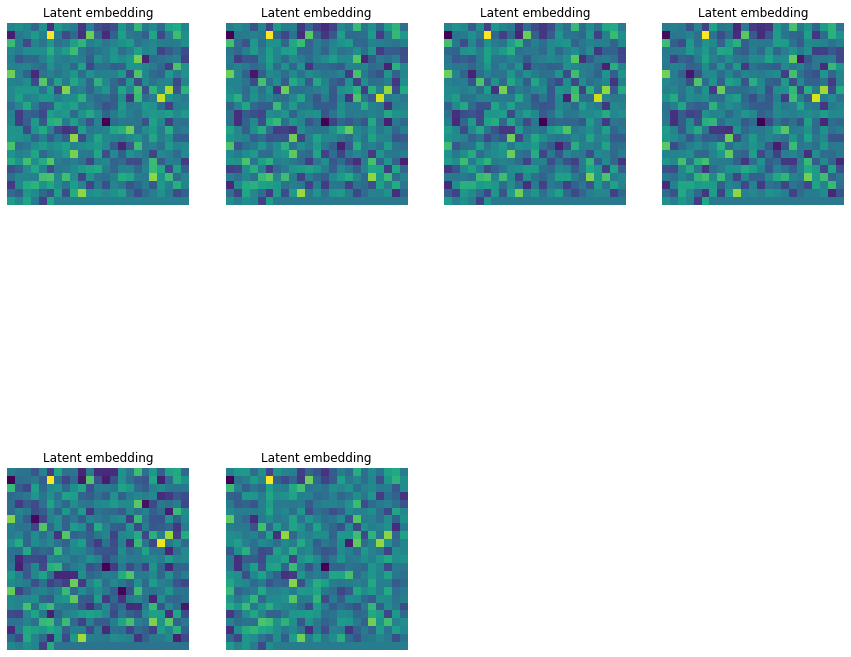

In [29]:
plot_pics(latent_embeddings, mode="latent_embeddings")

In [30]:
reconstructed = eval_autoencoder(autoencoder, latent_embeddings, mode="decode")

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

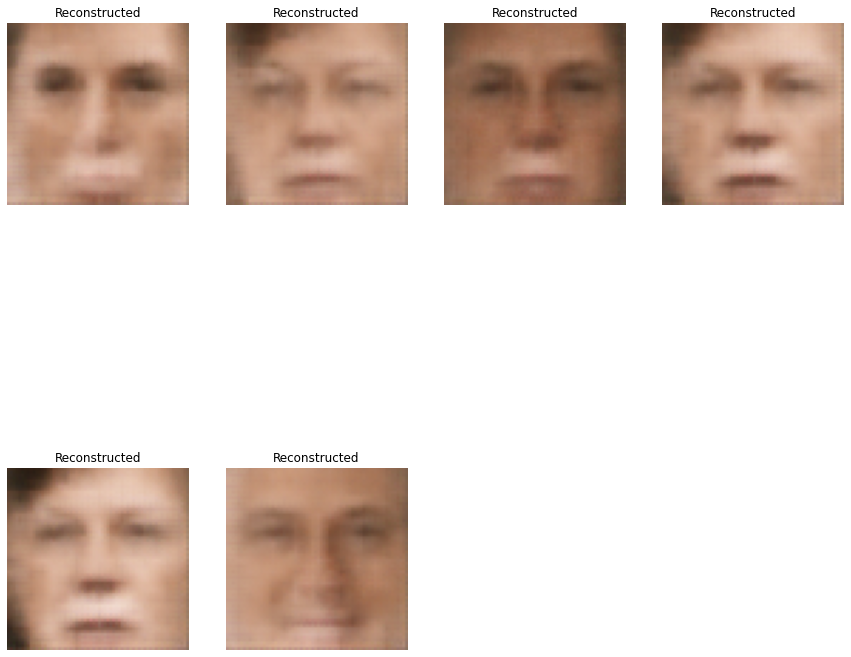

In [31]:
plot_pics(reconstructed, mode="reconstructions")

Not bad, right? 

### 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

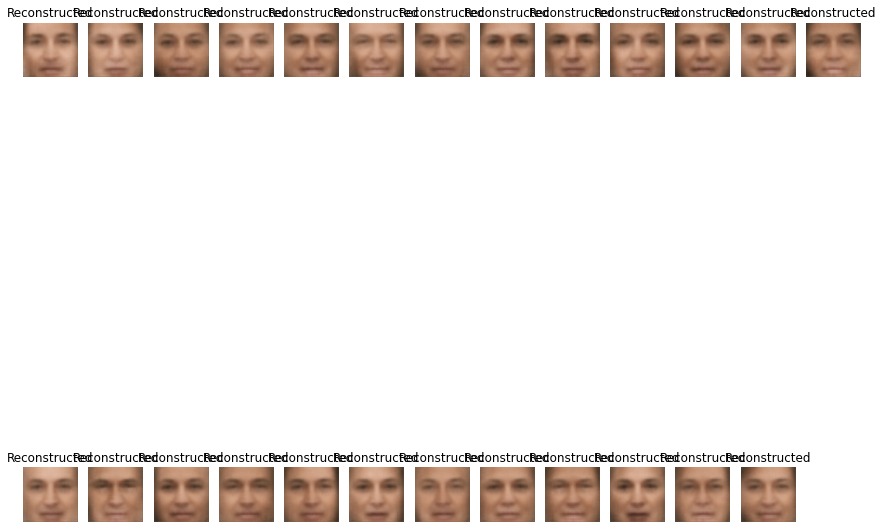

In [32]:
# сгенерируем 25 рандомных векторов размера latent_space
z = [torch.normal(mean=torch.mean(latent_embeddings, dim=0), std=torch.std(latent_embeddings, dim=0)) for i in range(25)]
z = torch.flatten(torch.stack(z), end_dim=0)
output = torch.sigmoid(autoencoder.decode(z.to(DEVICE)).detach().cpu())
plot_pics(output, mode="reconstructions", sample_size=25)
z = z.to("cpu")
del z
torch.cuda.empty_cache()

### Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутству.щие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [33]:
def get_latent_embeddings_by_features(attrs, features, orders, train, val, test):
    sorted_attrs = attrs.sort_values(features, ascending=orders)[:15]
    idx_best = np.sort(sorted_attrs.index.to_numpy())
    train_idx_best = idx_best[np.where(idx_best < len(train))]
    val_idx_best = idx_best[np.where(((idx_best >= len(train)) & (idx_best < len(train) + len(val))))] - len(train)
    test_idx_best = idx_best[np.where(((idx_best >= len(train) + len(val)) & (idx_best < len(train) + len(val) + len(test))))] - (len(train) + len(val))
    photos_best = torch.Tensor(np.concatenate((train[train_idx_best], val[val_idx_best], test[test_idx_best]))).permute(0, 3, 1, 2)
    data_best = data_utils.DataLoader(photos_best, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, 
                                              num_workers=torch.multiprocessing.cpu_count())
    return data_best

In [34]:
data_smiling = get_latent_embeddings_by_features(attrs, ["Mouth Wide Open", "Teeth Not Visible"], [False, True], train, val, test)

In [35]:
latent_embeddings_smiling = eval_autoencoder(autoencoder, data_smiling, mode="encode")

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

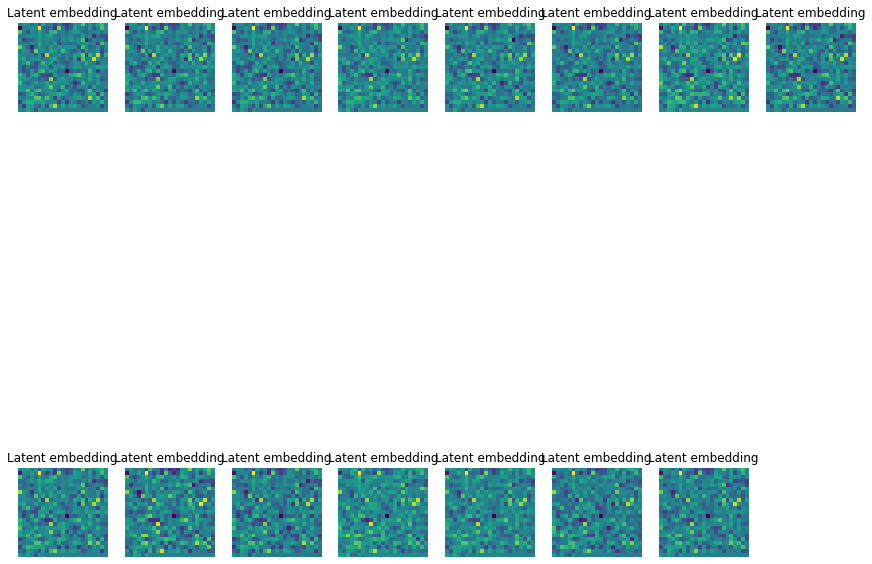

In [36]:
plot_pics(latent_embeddings_smiling, mode="latent_embeddings", sample_size=len(latent_embeddings_smiling))

In [37]:
data_frowning = get_latent_embeddings_by_features(attrs, ["Mouth Wide Open", "Teeth Not Visible"], [True, False], train, val, test)

In [38]:
latent_embeddings_frowning = eval_autoencoder(autoencoder, data_frowning, mode="encode")

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

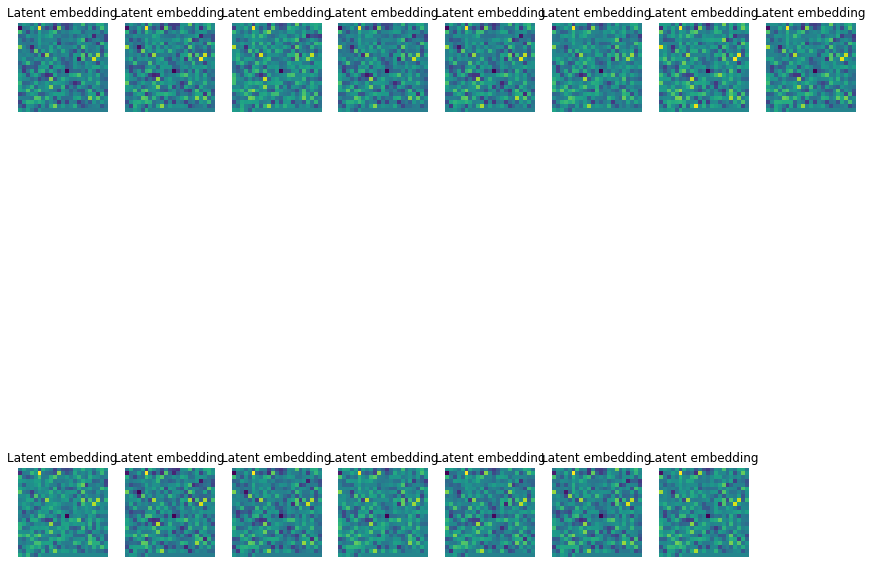

In [39]:
plot_pics(latent_embeddings_frowning, mode="latent_embeddings", sample_size=len(latent_embeddings_frowning))

In [40]:
defrowner_vector = torch.mean(latent_embeddings_smiling, dim=0) - torch.mean(latent_embeddings_frowning, dim=0)

In [41]:
latent_embeddings_defrowned = latent_embeddings_frowning + defrowner_vector

In [42]:
frowning = eval_autoencoder(autoencoder, latent_embeddings_frowning, mode="decode")

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

In [43]:
defrowned = eval_autoencoder(autoencoder, latent_embeddings_defrowned, mode="decode")

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

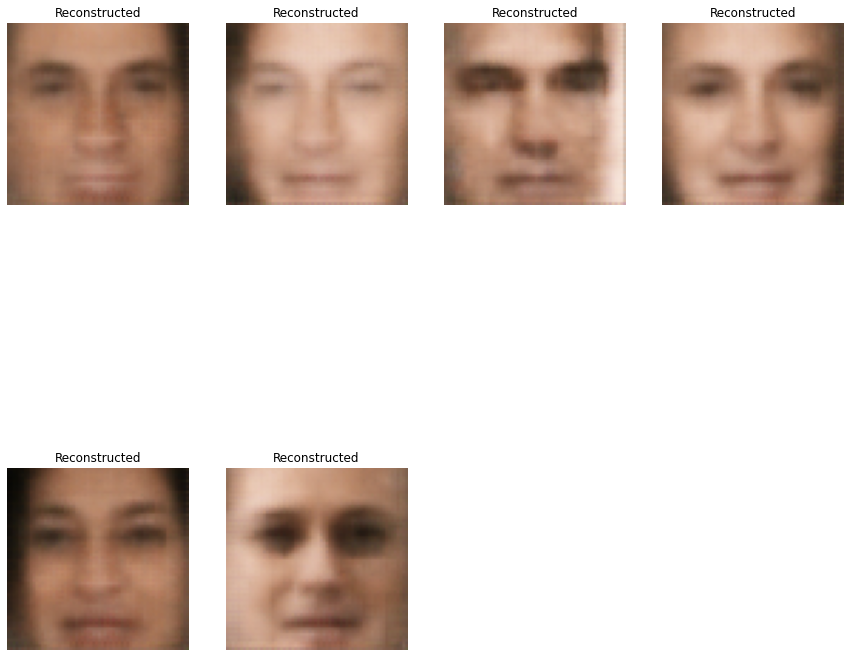

In [44]:
plot_pics(frowning, mode="reconstructions")

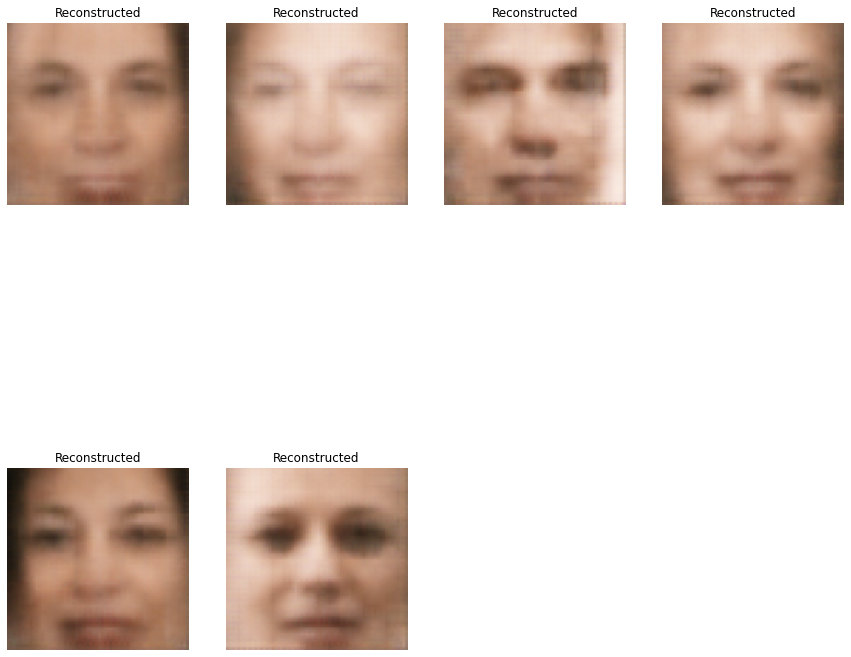

In [45]:
plot_pics(defrowned, mode="reconstructions")

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

In [46]:
autoencoder = autoencoder.to("cpu")
del autoencoder

## Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

### Loading data

In [12]:
# MNIST Dataset
train_dataset = torchvision.datasets.MNIST(root='./mnist_data/', train=True, transform=torchvision.transforms.ToTensor(), download=True)
train_dataset, val_dataset = data_utils.random_split(train_dataset, [int(0.7 * len(train_dataset)), len(train_dataset) - int(0.7 * len(train_dataset))], 
                                                     generator=torch.Generator().manual_seed(RANDOM_STATE))
test_dataset = torchvision.datasets.MNIST(root='./mnist_data/', train=False, transform=torchvision.transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                                           num_workers=torch.multiprocessing.cpu_count(), drop_last=True)
val_loader = data_utils.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                                   num_workers=torch.multiprocessing.cpu_count(), drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                                          num_workers=torch.multiprocessing.cpu_count(), drop_last=True)

### 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [13]:
LATENT_SPACE_SIZE = 32

In [49]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder_backbone = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Flatten(start_dim=1),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
        )
        self.encoder_head_mu = nn.Linear(64, LATENT_SPACE_SIZE)
        self.encoder_head_logvar = nn.Linear(64, LATENT_SPACE_SIZE)
        self.decoder_tail = nn.Sequential(
            nn.Linear(LATENT_SPACE_SIZE, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 256),
            nn.ReLU(inplace=True),
            nn.Unflatten(dim=1, unflattened_size=(64, 2, 2))
        )
        self.decoder_backbone = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=3, output_padding=1),
        )

    def encode(self, x):
        conved_input = self.encoder_backbone(x)
        mu = self.encoder_head_mu(conved_input)
        logvar = self.encoder_head_logvar(conved_input)
        return mu, logvar
    
    def gaussian_sampler(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            latent_vector = mu + (eps * std)
            return latent_vector
        else:
            return mu
    
    def decode(self, z):
        permuted_latent = self.decoder_tail(z)
        reconstruction = self.decoder_backbone(permuted_latent)
        return reconstruction

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.gaussian_sampler(mu, logvar)
        reconstruction = self.decode(z)
        return mu, logvar, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [14]:
def KL_divergence(mu, logvar):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return loss

def log_likelihood(inputs, targets):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction="sum")
    return loss(inputs, targets)

def loss_vae(inputs, targets, mu, logvar):
    return log_likelihood(inputs, targets) + KL_divergence(mu, logvar)

In [51]:
variational_ae = VAE().to(DEVICE)

In [52]:
torchinfo.summary(variational_ae, (BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      --                        --
├─Sequential: 1-1                        [256, 64]                 --
│    └─Conv2d: 2-1                       [256, 8, 16, 16]          80
│    └─ReLU: 2-2                         [256, 8, 16, 16]          --
│    └─Conv2d: 2-3                       [256, 16, 8, 8]           1,168
│    └─BatchNorm2d: 2-4                  [256, 16, 8, 8]           32
│    └─ReLU: 2-5                         [256, 16, 8, 8]           --
│    └─Conv2d: 2-6                       [256, 32, 4, 4]           4,640
│    └─ReLU: 2-7                         [256, 32, 4, 4]           --
│    └─Conv2d: 2-8                       [256, 64, 2, 2]           18,496
│    └─BatchNorm2d: 2-9                  [256, 64, 2, 2]           128
│    └─ReLU: 2-10                        [256, 64, 2, 2]           --
│    └─Flatten: 2-11                     [256, 256]                --
│   

In [53]:
!nvidia-smi

Fri Dec 31 11:57:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   71C    P0    N/A /  N/A |    757MiB /  3020MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Modifying and/or adding training and inference functions

In [15]:
def fit_epoch(train_loader, model, optimizer, criterion):
    model.train()
    running_loss = 0.0
    processed_data = 0
    for inputs, _ in tqdm.tqdm(train_loader, desc="Fitting"):
        try:
            inputs = inputs.to(DEVICE)
            optimizer.zero_grad()
            mu, logvar, reconstructions = model(inputs)
            loss = criterion(torch.sigmoid(reconstructions), inputs, mu, logvar)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            processed_data += inputs.size(0)

            # clearing VRAM
            inputs = inputs.to("cpu")
            del inputs
            torch.cuda.empty_cache()
        except Exception as e:
            # clearing VRAM and reraising error
            inputs = inputs.to("cpu")
            del inputs
            torch.cuda.empty_cache()
            raise e
    train_loss = running_loss / processed_data
    return train_loss
  
def eval_epoch(val_loader, model, criterion):
    model.eval()
    running_loss = 0.0
    processed_data = 0

    for inputs, _ in tqdm.tqdm(val_loader, desc="Validating"):
        try:
            inputs = inputs.to(DEVICE)
            with torch.no_grad():
                mu, logvar, reconstructions = model(inputs)
                loss = criterion(torch.sigmoid(reconstructions), inputs, mu, logvar)

            running_loss += loss.item() * inputs.size(0)
            processed_data += inputs.size(0)

            # clearing VRAM
            inputs = inputs.to("cpu")
            del inputs
            torch.cuda.empty_cache()
        except Exception as e:
            # clearing VRAM and reraising error
            inputs = inputs.to("cpu")
            del inputs
            torch.cuda.empty_cache()
            raise e
    val_loss = running_loss / processed_data
    return reconstructions, None, val_loss

def show_pics_train(val_loader, outputs, model, epoch, val_loss, sample_size=6):
    model.eval()
    inputs, _ = next(iter(val_loader))
    originals = inputs.permute(0, 2, 3, 1).cpu()
    mu, logvar = model.encode(inputs.to(DEVICE))
    mu, logvar = mu.detach().cpu(), logvar.detach().cpu()
    latent_embeddings = model.gaussian_sampler(mu, logvar).detach().cpu()
    if not int(np.sqrt(latent_embeddings.shape[1])) == np.sqrt(latent_embeddings.shape[1]):
        latent_embeddings = F.pad(latent_embeddings, (0, int(np.ceil(np.sqrt(latent_embeddings.shape[1])) ** 2 - latent_embeddings.shape[1])))
    _, _, reconstructions = model(inputs.to(DEVICE))
    reconstructions = torch.sigmoid(reconstructions).permute(0, 2, 3, 1).detach().cpu()
    for i in range(sample_size):
        plt.subplot(3, sample_size, i + 1)
        plt.imshow(originals[i].numpy())
        plt.title("Real")
        plt.axis("off")

        plt.subplot(3, sample_size, i + 1 + sample_size)
        plt.imshow(latent_embeddings[i].reshape(int(np.sqrt(len(latent_embeddings[i]))), -1))
        plt.title("Latent embedding")
        plt.axis("off")

        plt.subplot(3, sample_size, i + 1 + 2 * sample_size)
        plt.imshow(reconstructions[i].numpy())
        plt.title("Reconstruction")
        plt.axis("off")
    plt.suptitle("Epoch %d, loss: %f" % (epoch + 1, val_loss))
    plt.show()
    inputs = inputs.to("cpu")
    del inputs
    torch.cuda.empty_cache()

In [16]:
def eval_variational_ae(model, data, mode="decode"):
    if mode == "decode":
        run_f = model.decode
        data = data_utils.DataLoader([data, data], batch_size=BATCH_SIZE, shuffle=False, 
                                    num_workers=torch.multiprocessing.cpu_count(), 
                                    drop_last=False)
    elif mode == "encode":
        run_f = model.encode
    else:
        raise ValueError("Unknown evaluation mode")
    model.eval()  # testing mode
    with torch.no_grad():
        results = []
        for X_batch, _ in tqdm.tqdm(data, desc="Evaluating"):
            try:
                X_batch = X_batch.to(DEVICE)
                if mode == "decode":
                    outputs = run_f(X_batch).detach().cpu()
                    outputs = torch.sigmoid(outputs)
                else:
                    mu, logvar = run_f(X_batch)
                    outputs = torch.flatten(torch.stack((mu.detach().cpu(), logvar.detach().cpu())), end_dim=1)
                results.append(outputs)
                X_batch = X_batch.to("cpu")
                del X_batch
                torch.cuda.empty_cache()
            except Exception as e:
                X_batch = X_batch.to("cpu")
                del X_batch
                torch.cuda.empty_cache()
                raise e

    return torch.flatten(torch.stack(results), end_dim=1)

In [17]:
def mass_reparametrize(model, mus, logvars):
    model.eval()
    with torch.no_grad():
        results = []
        for mu, logvar in tqdm.tqdm(zip(mus, logvars), desc="Reparametrizing"):
            try:
                latent_embedding = model.gaussian_sampler(mu.to(DEVICE), logvar.to(DEVICE)).detach().cpu()
                results.append(latent_embedding)
                mu, logvar = mu.to("cpu"), logvar.to("cpu")
                del mu, logvar
                torch.cuda.empty_cache()
            except Exception as e:
                mu, logvar = mu.to("cpu"), logvar.to("cpu")
                del mu. logvar
                torch.cuda.empty_cache()
                raise e
                
    return torch.stack(results)

### Training VAE

И обучим модель:

In [57]:
criterion = loss_vae
optimizer = torch.optim.AdamW(variational_ae.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, cooldown=5, threshold=0.01, verbose=True)


Epoch  100 train_loss:  27492.1611     val_loss  26589.1341


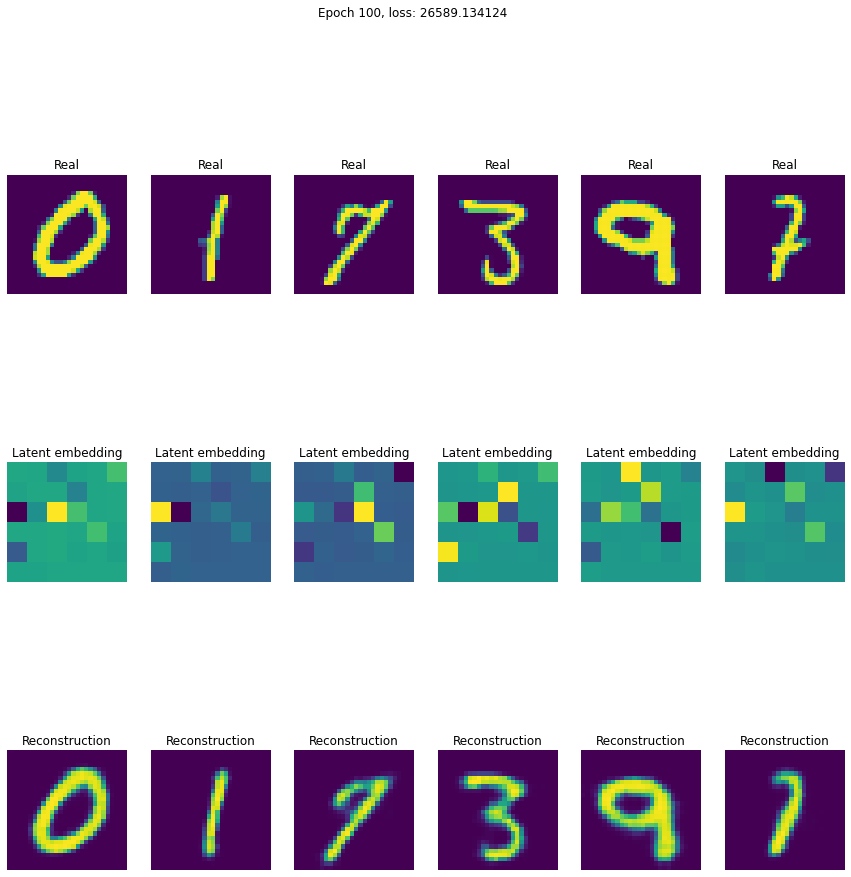

Overall training time:  732.1 seconds


In [58]:
max_epochs = 100
history_variational_ae = train_model(train_loader, val_loader, variational_ae, optimizer, criterion, max_epochs, BATCH_SIZE, scheduler=scheduler)

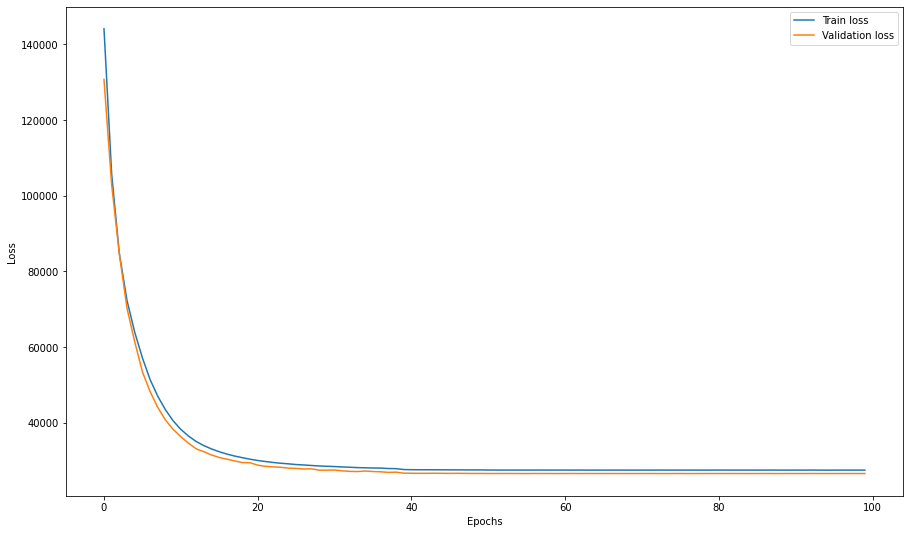

In [59]:
plot_loss(history_variational_ae)

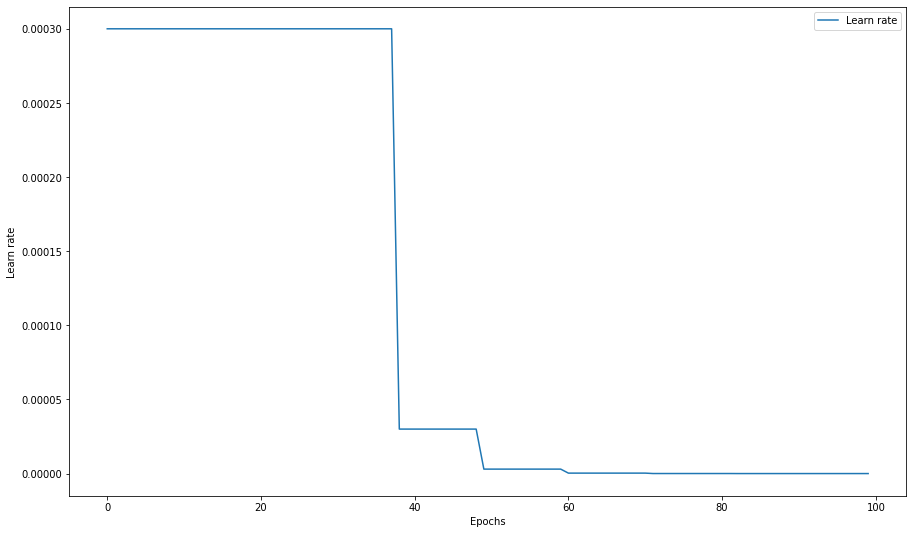

In [60]:
plot_learn_rate(history_variational_ae)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

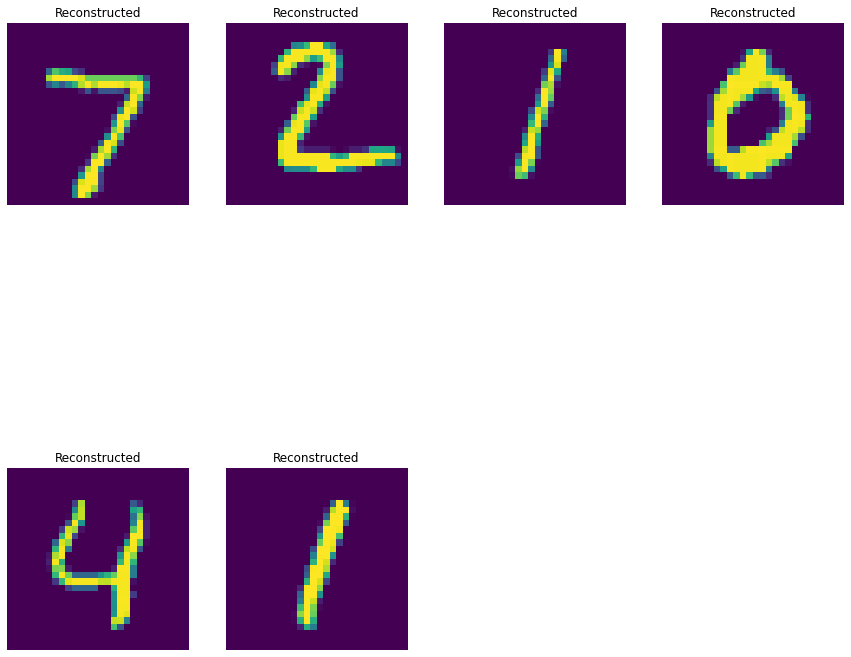

In [61]:
plot_pics(next(iter(test_loader))[0], mode="reconstructions")

In [62]:
mu_logvars = eval_variational_ae(variational_ae, test_loader, mode="encode")

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

In [63]:
mus, logvars = torch.index_select(mu_logvars, 0, torch.Tensor([i for i in range(len(mu_logvars)) if i % 2 == 0]).int()),\
                torch.index_select(mu_logvars, 0, torch.Tensor([i for i in range(len(mu_logvars)) if i % 2 != 0]).int())

In [64]:
latent_embeddings = mass_reparametrize(variational_ae, mus, logvars)

Reparametrizing: 0it [00:00, ?it/s]

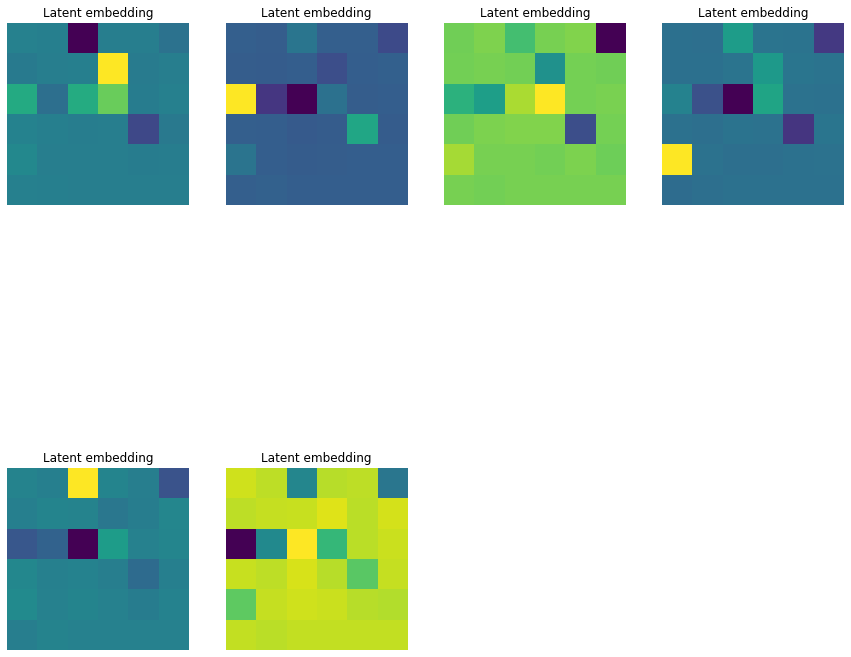

In [65]:
plot_pics(latent_embeddings, mode="latent_embeddings")

In [66]:
reconstructions = eval_variational_ae(variational_ae, latent_embeddings, mode="decode")

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

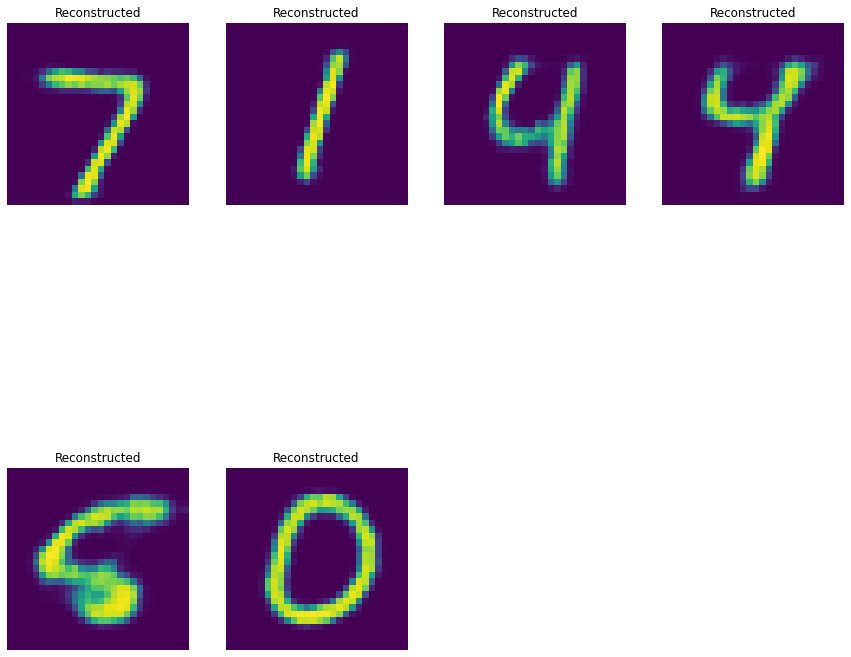

In [67]:
plot_pics(reconstructions, mode="reconstructions")

### VAE Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

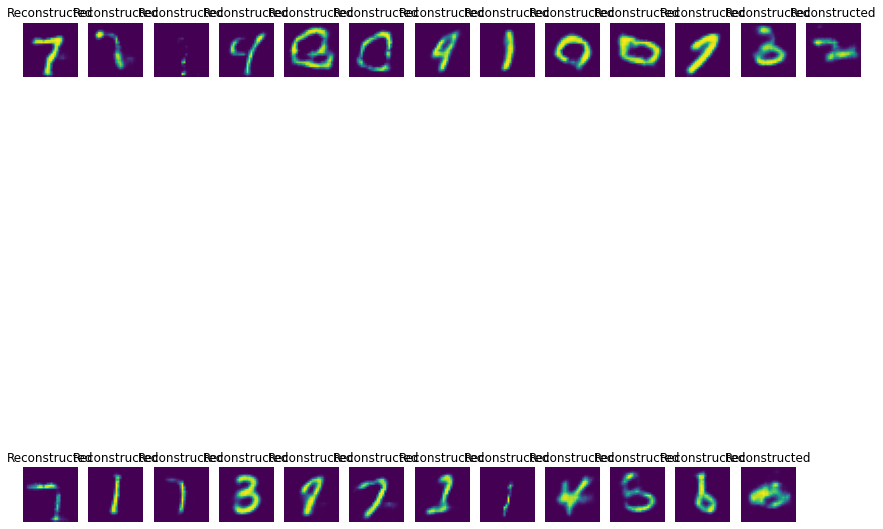

In [68]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
# сгенерируем 25 рандомных векторов размера latent_space
z = torch.flatten(torch.stack([torch.normal(mean=mus[i], std=(0.5 * logvars[i]).exp()) for i in range(25)]), end_dim=0)
output = torch.sigmoid(variational_ae.decode(z.to(DEVICE)).detach().cpu())
plot_pics(output, mode="reconstructions", sample_size=25)
z = z.to("cpu")
del z
torch.cuda.empty_cache()

### 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощью `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [69]:
latent_compressed = sklearn.manifold.TSNE(n_components=2, verbose=1).fit_transform(latent_embeddings.numpy())
print("[t-SNE] Done.")

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9984 samples in 0.001s...
[t-SNE] Computed neighbors for 9984 samples in 3.276s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9984
[t-SNE] Computed conditional probabilities for sample 2000 / 9984
[t-SNE] Computed conditional probabilities for sample 3000 / 9984
[t-SNE] Computed conditional probabilities for sample 4000 / 9984
[t-SNE] Computed conditional probabilities for sample 5000 / 9984
[t-SNE] Computed conditional probabilities for sample 6000 / 9984
[t-SNE] Computed conditional probabilities for sample 7000 / 9984
[t-SNE] Computed conditional probabilities for sample 8000 / 9984
[t-SNE] Computed conditional probabilities for sample 9000 / 9984
[t-SNE] Computed conditional probabilities for sample 9984 / 9984
[t-SNE] Mean sigma: 0.263529
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.668594
[t-SNE] KL divergence after 1000 iterations: 1.567467
[t-SNE] Done.


In [18]:
def plot_latent_compressed(data, latent_embeddings, num_classes=10):
    plt.figure(figsize=(20, 10))
    d = {i:[] for i in range(num_classes)}

    targets = []
    for i, (_, Y) in tqdm.tqdm(enumerate(data), desc="Retrieving targets"):
        targets.append(Y)
    targets = torch.flatten(torch.stack(targets), end_dim=1)
    
    for j in range(num_classes):
        if j in targets:
            mask = (targets == j)
            d[j].append(latent_embeddings[mask])

    colors = list(matplotlib.colors.TABLEAU_COLORS.items())
    for i in range(num_classes):
        d[i] = np.concatenate(d[i])
        plt.scatter(d[i][:, 0], d[i][:, 1], c=colors[i][1], label=f"{i}", alpha=0.5)
        
    kmeans = sklearn.cluster.KMeans(n_clusters=num_classes)
    X = np.concatenate(list(d.values()))
    labels = kmeans.fit_predict(X)
    centroids = kmeans.cluster_centers_
    for i, center in enumerate(centroids):
        plt.text(center[0], center[1], str(i), fontdict={"size": 20, "weight": "bold"})
        
    plt.title("VAE latent vector distribution (MNIST)")
    plt.colorbar()
    plt.legend()
    plt.plot();

Retrieving targets: 0it [00:00, ?it/s]

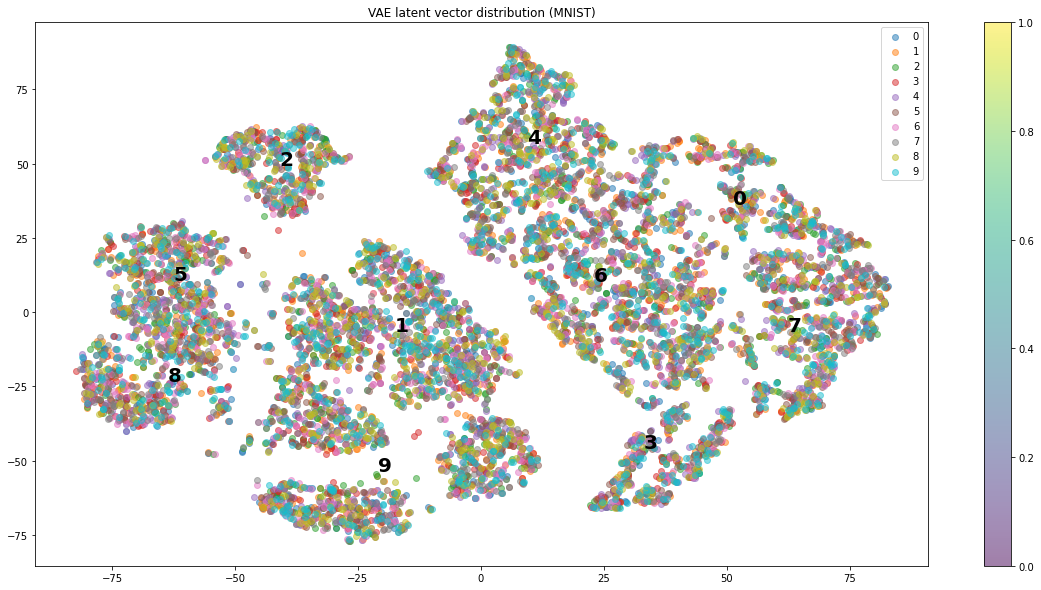

In [71]:
plot_latent_compressed(test_loader, latent_compressed)

Что вы думаете о виде латентного представления?

 — Кластеры распределения находятся довольно близко в некоторых случаях, но в целом картина адекватная.

__Congrats v2.0!__

## 3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [19]:
class CVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder_backbone = nn.Sequential(
            nn.Conv2d(1 + 10, 8, kernel_size=3, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Flatten(start_dim=1),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
        )
        self.encoder_head_mu = nn.Linear(64, LATENT_SPACE_SIZE)
        self.encoder_head_logvar = nn.Linear(64, LATENT_SPACE_SIZE)
        self.decoder_tail = nn.Sequential(
            nn.Linear(LATENT_SPACE_SIZE + 10, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 256),
            nn.ReLU(inplace=True),
            nn.Unflatten(dim=1, unflattened_size=(64, 2, 2))
        )
        self.decoder_backbone = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=3, output_padding=1),
        )
        
    def _onehot_targets(self, targets):
        targets_onehot = torch.zeros(targets.shape[0], 10).to(DEVICE)
        targets_onehot.scatter_(1, targets.view(-1, 1).to(torch.int64), 1)
        return targets_onehot

    def encode(self, x, targets):
        targets_onehot = self._onehot_targets(targets).view(-1, 10, 1, 1)
        ones = torch.ones(x.shape[0], 10, x.shape[2], x.shape[3], dtype=x.dtype).to(DEVICE)
        ones *= targets_onehot
        x = torch.cat((x, ones), dim=1)
        conved_input = self.encoder_backbone(x)
        mu = self.encoder_head_mu(conved_input)
        logvar = self.encoder_head_logvar(conved_input)
        return mu, logvar
    
    def gaussian_sampler(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            latent_vector = mu + (eps * std)
            return latent_vector
        else:
            return mu
    
    def decode(self, z, targets):
        onehot_targets = self._onehot_targets(targets)
        z = torch.cat((z, onehot_targets), dim=1)
        permuted_latent = self.decoder_tail(z)
        reconstruction = self.decoder_backbone(permuted_latent)
        return reconstruction

    def forward(self, x, targets):
        mu, logvar = self.encode(x, targets)
        z = self.gaussian_sampler(mu, logvar)
        reconstruction = self.decode(z, targets)
        return mu, logvar, reconstruction

In [20]:
conditional_vae = CVAE().to(DEVICE)

In [21]:
torchinfo.summary(conditional_vae, ((BATCH_SIZE, 1, 28, 28), (BATCH_SIZE,)))

Layer (type:depth-idx)                   Output Shape              Param #
CVAE                                     --                        --
├─Sequential: 1-1                        [256, 64]                 --
│    └─Conv2d: 2-1                       [256, 8, 16, 16]          800
│    └─ReLU: 2-2                         [256, 8, 16, 16]          --
│    └─Conv2d: 2-3                       [256, 16, 8, 8]           1,168
│    └─BatchNorm2d: 2-4                  [256, 16, 8, 8]           32
│    └─ReLU: 2-5                         [256, 16, 8, 8]           --
│    └─Conv2d: 2-6                       [256, 32, 4, 4]           4,640
│    └─ReLU: 2-7                         [256, 32, 4, 4]           --
│    └─Conv2d: 2-8                       [256, 64, 2, 2]           18,496
│    └─BatchNorm2d: 2-9                  [256, 64, 2, 2]           128
│    └─ReLU: 2-10                        [256, 64, 2, 2]           --
│    └─Flatten: 2-11                     [256, 256]                --
│  

In [22]:
!nvidia-smi

Fri Dec 31 12:26:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   69C    P0    N/A /  N/A |    739MiB /  3020MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Modifying and/or adding training and inference functions

In [23]:
def fit_epoch(train_loader, model, optimizer, criterion):
    model.train()
    running_loss = 0.0
    processed_data = 0
    for inputs, targets in tqdm.tqdm(train_loader, desc="Fitting"):
        try:
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            optimizer.zero_grad()
            mu, logvar, reconstructions = model(inputs, targets)
            loss = criterion(torch.sigmoid(reconstructions), inputs, mu, logvar)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            processed_data += inputs.size(0)

            # clearing VRAM
            inputs = inputs.to("cpu")
            targets = targets.to("cpu")
            del inputs
            del targets
            torch.cuda.empty_cache()
        except Exception as e:
            # clearing VRAM and reraising error
            inputs = inputs.to("cpu")
            targets = targets.to("cpu")
            del inputs
            del targets
            torch.cuda.empty_cache()
            raise e
    train_loss = running_loss / processed_data
    return train_loss
  
def eval_epoch(val_loader, model, criterion):
    model.eval()
    running_loss = 0.0
    processed_data = 0

    for inputs, targets in tqdm.tqdm(val_loader, desc="Validating"):
        try:
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            with torch.no_grad():
                mu, logvar, reconstructions = model(inputs, targets)
                loss = criterion(torch.sigmoid(reconstructions), inputs, mu, logvar)

            running_loss += loss.item() * inputs.size(0)
            processed_data += inputs.size(0)

            # clearing VRAM
            inputs = inputs.to("cpu")
            targets = targets.to("cpu")
            del inputs
            del targets
            torch.cuda.empty_cache()
        except Exception as e:
            # clearing VRAM and reraising error
            inputs = inputs.to("cpu")
            targets = targets.to("cpu")
            del inputs
            del targets
            torch.cuda.empty_cache()
            raise e
    val_loss = running_loss / processed_data
    return reconstructions, None, val_loss

def show_pics_train(val_loader, outputs, model, epoch, val_loss, sample_size=6):
    model.eval()
    inputs, targets = next(iter(val_loader))
    originals = inputs.permute(0, 2, 3, 1).cpu()
    mu, logvar = model.encode(inputs.to(DEVICE), targets.to(DEVICE))
    mu, logvar = mu.detach().cpu(), logvar.detach().cpu()
    latent_embeddings = model.gaussian_sampler(mu, logvar).detach().cpu()
    if not int(np.sqrt(latent_embeddings.shape[1])) == np.sqrt(latent_embeddings.shape[1]):
        latent_embeddings = F.pad(latent_embeddings, (0, int(np.ceil(np.sqrt(latent_embeddings.shape[1])) ** 2 - latent_embeddings.shape[1])))
    _, _, reconstructions = model(inputs.to(DEVICE), targets.to(DEVICE))
    reconstructions = torch.sigmoid(reconstructions).permute(0, 2, 3, 1).detach().cpu()
    for i in range(sample_size):
        plt.subplot(3, sample_size, i + 1)
        plt.imshow(originals[i].numpy())
        plt.title("Real")
        plt.axis("off")

        plt.subplot(3, sample_size, i + 1 + sample_size)
        plt.imshow(latent_embeddings[i].reshape(int(np.sqrt(len(latent_embeddings[i]))), -1))
        plt.title("Latent embedding")
        plt.axis("off")

        plt.subplot(3, sample_size, i + 1 + 2 * sample_size)
        plt.imshow(reconstructions[i].numpy())
        plt.title("Reconstruction")
        plt.axis("off")
    plt.suptitle("Epoch %d, loss: %f" % (epoch + 1, val_loss))
    plt.show()
    inputs = inputs.to("cpu")
    targets = targets.to("cpu")
    del inputs
    del targets
    torch.cuda.empty_cache()

In [24]:
def eval_conditional_vae(model, data, mode="decode"):
    if mode == "decode":
        run_f = model.decode
        data = data_utils.DataLoader([data, data], batch_size=BATCH_SIZE, shuffle=False, 
                                    num_workers=torch.multiprocessing.cpu_count(), 
                                    drop_last=False)
    elif mode == "encode":
        run_f = model.encode
    else:
        raise ValueError("Unknown evaluation mode")
    model.eval()  # testing mode
    with torch.no_grad():
        results = []
        for X_batch, y_batch in tqdm.tqdm(data, desc="Evaluating"):
            try:
                X_batch = X_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                if mode == "decode":
                    outputs = run_f(X_batch, y_batch).detach().cpu()
                    outputs = torch.sigmoid(outputs)
                else:
                    mu, logvar = run_f(X_batch, y_batch)
                    outputs = torch.flatten(torch.stack((mu.detach().cpu(), logvar.detach().cpu())), end_dim=1)
                results.append(outputs)
                X_batch = X_batch.to("cpu")
                y_batch = y_batch.to("cpu")
                del X_batch
                del y_batch
                torch.cuda.empty_cache()
            except Exception as e:
                X_batch = X_batch.to("cpu")
                y_batch = y_batch.to("cpu")
                del X_batch
                del y_batch
                torch.cuda.empty_cache()
                raise e

    return torch.flatten(torch.stack(results), end_dim=1)

### Training CVAE

In [25]:
criterion = loss_vae
optimizer = torch.optim.AdamW(conditional_vae.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, cooldown=5, threshold=0.01, verbose=True)


Epoch  100 train_loss:  25776.9725     val_loss  25037.2391


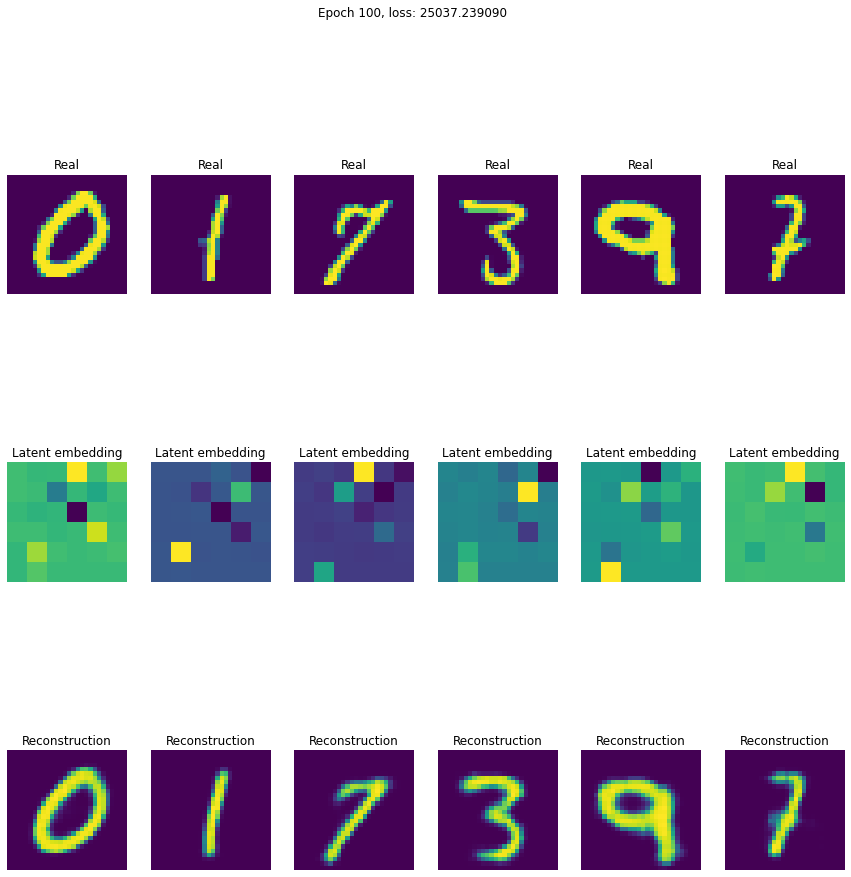

Overall training time:  820.3 seconds


In [26]:
max_epochs = 100
history_conditional_vae = train_model(train_loader, val_loader, conditional_vae, optimizer, criterion, max_epochs, BATCH_SIZE, scheduler=scheduler)

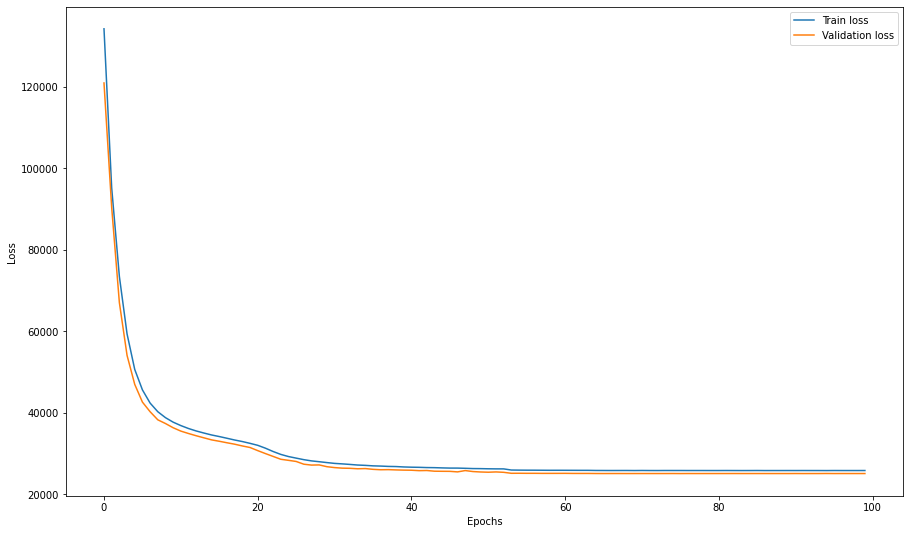

In [27]:
plot_loss(history_conditional_vae)

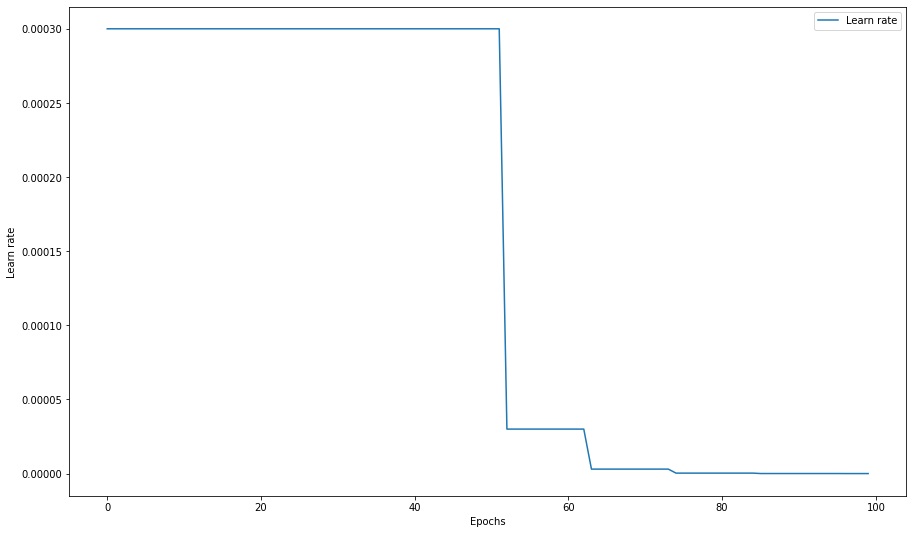

In [28]:
plot_learn_rate(history_conditional_vae)

### CVAE Sampling

Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [29]:
mu_logvars = eval_conditional_vae(conditional_vae, test_loader, mode="encode")
mus, logvars = torch.index_select(mu_logvars, 0, torch.Tensor([i for i in range(len(mu_logvars)) if i % 2 == 0]).int()),\
                torch.index_select(mu_logvars, 0, torch.Tensor([i for i in range(len(mu_logvars)) if i % 2 != 0]).int())

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

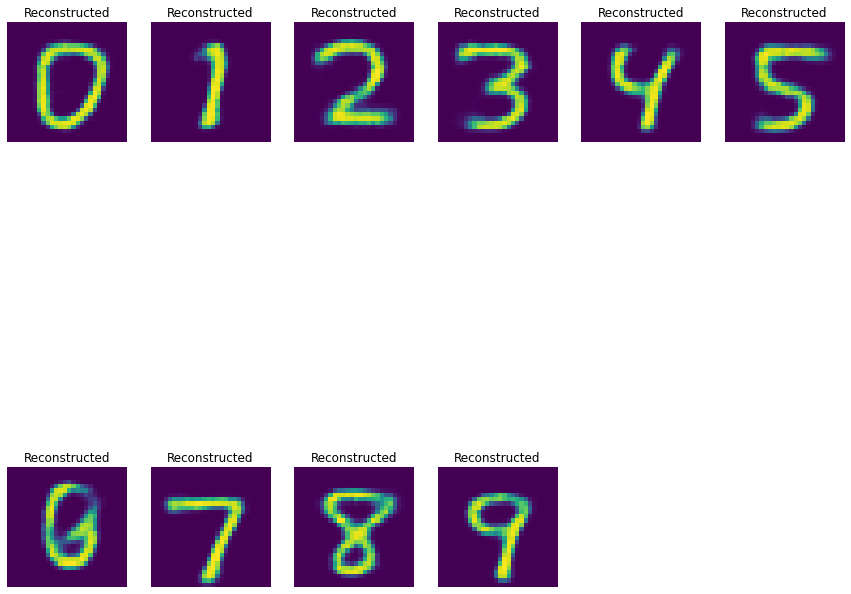

In [34]:
z = torch.flatten(torch.stack([torch.normal(mean=mus[i], std=(0.5 * logvars[i]).exp()) for i in range(25)]), end_dim=0)
# Let's generate 10 pics from one vector with different targets and 15 more random-target pictures
targets_class_check = torch.Tensor(list(range(10)))
targets_random = torch.Tensor(np.random.randint(0, 10, size=(15,)))
input_class_check = z[0].repeat(10, 1)
output_class_check = torch.sigmoid(conditional_vae.decode(input_class_check.to(DEVICE), targets_class_check.to(DEVICE)).detach().cpu())
output_random = torch.sigmoid(conditional_vae.decode(z[10:].to(DEVICE), targets_random.to(DEVICE)).detach().cpu())
plot_pics(output_class_check, mode="reconstructions", sample_size=10)

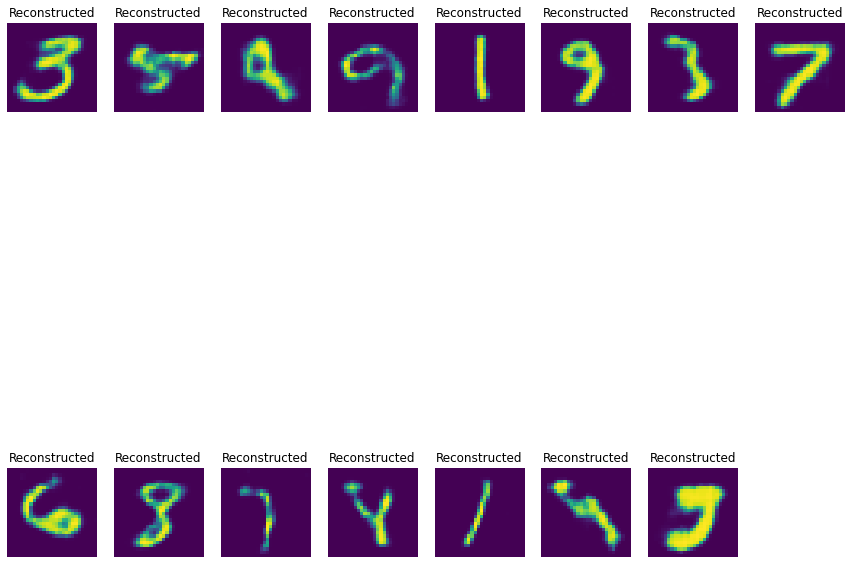

In [35]:
plot_pics(output_random, mode="reconstructions", sample_size=15)
z = z.to("cpu")
targets_class_check = targets_class_check.to("cpu")
targets_random = targets_random.to("cpu")
output_class_check = output_class_check.to("cpu")
output_random = output_random.to("cpu")
del z, targets_class_check, targets_random, output_class_check, output_random
torch.cuda.empty_cache()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [36]:
latent_embeddings = mass_reparametrize(conditional_vae, mus, logvars)
latent_compressed = sklearn.manifold.TSNE(n_components=2, verbose=1).fit_transform(latent_embeddings.numpy())
print("[t-SNE] Done.")

Reparametrizing: 0it [00:00, ?it/s]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9984 samples in 0.000s...
[t-SNE] Computed neighbors for 9984 samples in 2.625s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9984
[t-SNE] Computed conditional probabilities for sample 2000 / 9984
[t-SNE] Computed conditional probabilities for sample 3000 / 9984
[t-SNE] Computed conditional probabilities for sample 4000 / 9984
[t-SNE] Computed conditional probabilities for sample 5000 / 9984
[t-SNE] Computed conditional probabilities for sample 6000 / 9984
[t-SNE] Computed conditional probabilities for sample 7000 / 9984
[t-SNE] Computed conditional probabilities for sample 8000 / 9984
[t-SNE] Computed conditional probabilities for sample 9000 / 9984
[t-SNE] Computed conditional probabilities for sample 9984 / 9984
[t-SNE] Mean sigma: 0.213124
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.010513
[t-SNE] KL divergence after 1000 iterations: 1.900294
[t-SNE] Done.


Retrieving targets: 0it [00:00, ?it/s]

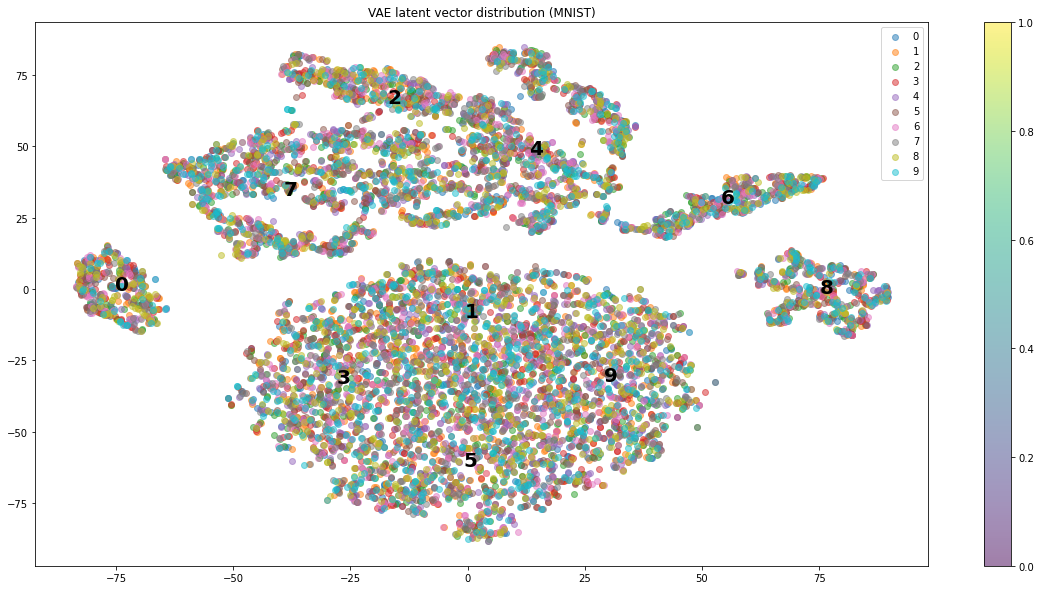

In [37]:
plot_latent_compressed(test_loader, latent_compressed)

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

 — Немного отличается распределением (распределение будто разделилось на два "пятна" по пять близких друг к другу классов каждое)

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>